In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from time import clock
import warnings
warnings.simplefilter('ignore')

In [2]:
# Import data
class_data = pd.read_csv("contraceptive.csv", header=None)
class_data.columns = ['w_age','w_ed', 'h_ed', 'n_child', 'w_rel', 'w_work', 'h_occ', 'sol', 'media', 'con_use']
X, y = class_data.iloc[:,:-1], class_data.iloc[:,-1]-1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(class_data)
print(class_data.describe())

      w_age  w_ed  h_ed  n_child  w_rel  w_work  h_occ  sol  media  con_use
0        24     2     3        3      1       1      2    3      0        1
1        45     1     3       10      1       1      3    4      0        1
2        43     2     3        7      1       1      3    4      0        1
3        42     3     2        9      1       1      3    3      0        1
4        36     3     3        8      1       1      3    2      0        1
5        19     4     4        0      1       1      3    3      0        1
6        38     2     3        6      1       1      3    2      0        1
7        21     3     3        1      1       0      3    2      0        1
8        27     2     3        3      1       1      3    4      0        1
9        45     1     1        8      1       1      2    2      1        1
10       38     1     3        2      1       0      3    3      1        1
11       42     1     4        4      1       1      1    3      0        1
12       44 

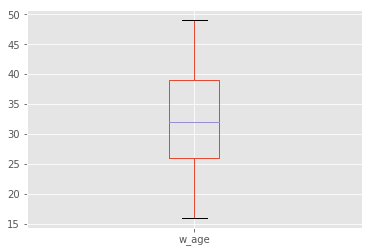

In [3]:
plt.style.use('ggplot')
class_data.boxplot(class_data.columns[0])

con_use
1    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
2    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
3    [[AxesSubplot(0.125,0.670278;0.215278x0.209722...
dtype: object

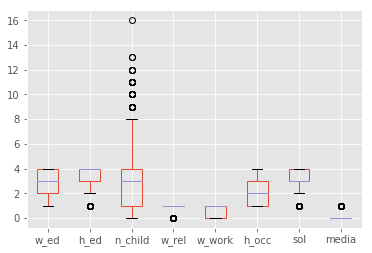

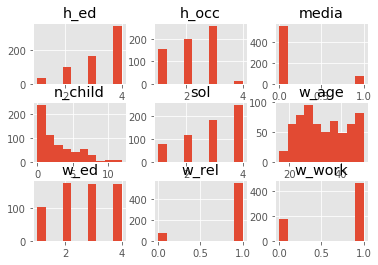

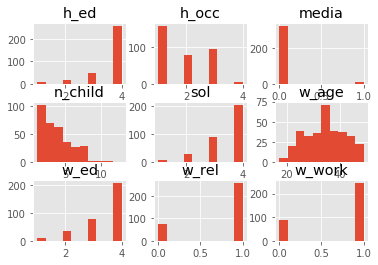

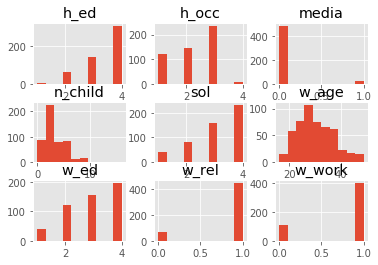

In [4]:
class_data.boxplot(list(class_data.columns[1:9]))
class_data.groupby('con_use').hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D1798F940>,
      dtype=object)

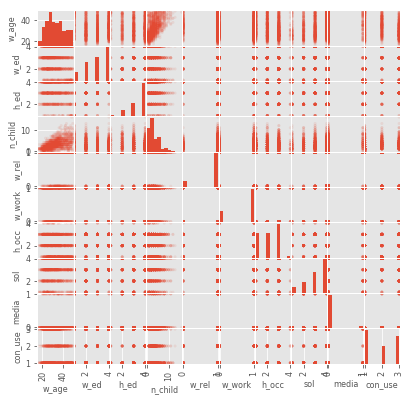

In [5]:
plt.rcParams['axes.labelsize'] = 8
scatter_matrix(class_data, alpha=0.1, figsize=(6.5,6.5))

In [6]:
class_data = class_data.astype({'w_rel':object,'w_work':object,'h_occ':object,'media':object})
categorical_mask = (class_data.dtypes == object)

pipeline = Pipeline([
    ('ohe_onestep', DictVectorizer(sparse=False)),
    ('standardscaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=123))
])

In [7]:
# Instantiate unpruned Decision Tree
start = clock()
pipeline.fit(X_train.to_dict('records'), y_train)
stop = clock()
print('Time to fit unpruned tree: {:.4f}'.format(stop-start))

# Predict and score results
start = clock()
y_pred = pipeline.predict(X_test.to_dict('records'))
stop = clock()
print('Time to predict unpruned tree: {:.4f}'.format(stop-start))
contra_acc_train = accuracy_score(y_train, pipeline.predict(X_train.to_dict('records')))
contra_acc_test = accuracy_score(y_test, y_pred)
print('Unpruned decision tree training accuracy: {:.3f}'.format(contra_acc_train))
print('Unpruned decision tree test accuracy: {:.3f}'.format(contra_acc_test))

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

Time to fit unpruned tree: 0.0581
Time to predict unpruned tree: 0.0124
Unpruned decision tree training accuracy: 0.962
Unpruned decision tree test accuracy: 0.488
[[79 14 26]
 [27 21 25]
 [40 19 44]]


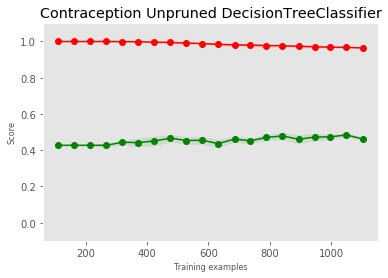

In [8]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X.to_dict('records'), y, n_jobs=-1, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Contraception Unpruned DecisionTreeClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()

In [9]:
# Define the grid of hyperparameters 'params_dt'
params_dt = {
    'clf__criterion': ['gini','entropy'],
    'clf__max_depth': range(3,12,1),
    'clf__min_samples_split': np.arange(0.01,0.10,0.01),
    'clf__min_samples_leaf': np.arange(0.05,0.15,0.01),
    'clf__max_features': np.arange(0.6,1,0.1)
}

# Perform RandomizedSearchCV
randomized = RandomizedSearchCV(pipeline, param_distributions=params_dt, n_iter=200, cv=4, scoring='accuracy',
                                refit=True, n_jobs = -1, verbose=1, random_state=123)

# Fit the estimator
start = clock()
randomized.fit(X_train.to_dict('records'), y_train)
stop = clock()
print('Time to hypertune: {:.3f}'.format(stop-start))

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:  4.2min


Time to hypertune: 255.091


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.2min finished


In [10]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', randomized.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(randomized.best_score_))

# Extract best model from 'grid'
best_model = randomized.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test.to_dict('records'), y_test)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc))

# Print CV confusion matrix
best_model.fit(X_train.to_dict('records'), y_train)
y_pred = best_model.predict(X_test.to_dict('records'))
print(confusion_matrix(y_test, y_pred))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(randomized.cv_results_['mean_fit_time'][randomized.best_index_]))
print('Mean score time: {:.4f}'.format(randomized.cv_results_['mean_score_time'][randomized.best_index_]))

Best hyperparameters:
 {'clf__min_samples_split': 0.04, 'clf__min_samples_leaf': 0.07, 'clf__max_features': 0.8999999999999999, 'clf__max_depth': 6, 'clf__criterion': 'entropy'}
Best CV accuracy: 0.556
Test set accuracy of best model: 0.580
[[90 11 18]
 [25 27 21]
 [34 15 54]]
Mean fit time: 0.0105
Mean score time: 0.0025


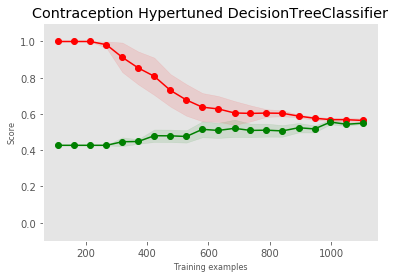

In [11]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X.to_dict('records'), y, n_jobs=-1, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Contraception Hypertuned DecisionTreeClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()